#### env: deepchem_py37 on MAC

In [63]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import List

from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import hdbscan

# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import os
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
#from rdkit.Chem import DataStructs
from rdkit.Chem import Draw
from molvs import standardize_smiles



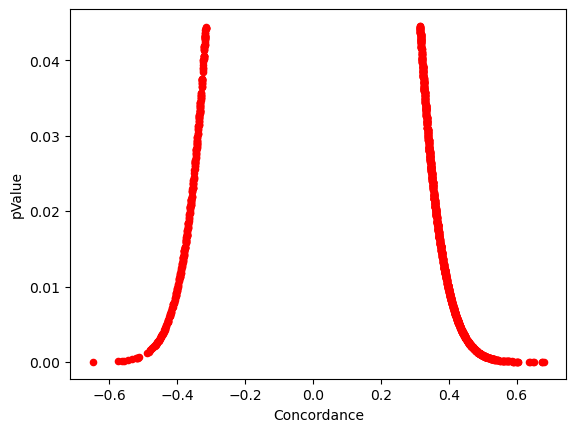

In [60]:
data = pd.read_excel('/Users/yanlixu/Desktop/pingan/合作/CDK12/220524/5_compounds_for_drug_combination.xlsx', sheet_name='Sheet1')
data.plot(kind='scatter',x='Concordance',y='pValue',color='red')
plt.show()

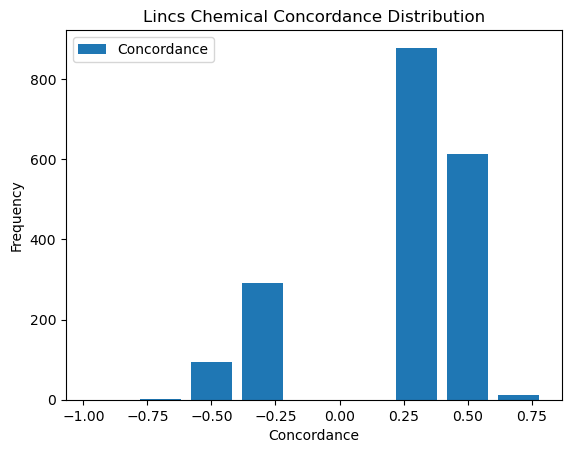

In [61]:
ax = data[['Concordance']].plot(kind='hist',bins=[i for i in np.arange(-1,1,0.2)],rwidth=0.8, title='Lincs Chemical Concordance Distribution')
ax.set_xlabel("Concordance")
plt.show()

In [64]:
cmp_smiles = pd.read_excel('/Users/yanlixu/Desktop/pingan/合作/CDK12/220524/5_compounds_for_drug_combination.xlsx', sheet_name='unique_cps_with_smiles')
cmp_smiles = cmp_smiles.drop_duplicates(subset=['Perturbagen'])
#cmp_smiles = cmp_smiles.dropna()
cmp_smiles = cmp_smiles.set_index('Perturbagen')
cmp_dict = cmp_smiles['smiles'].to_dict()

def get_smies(chem_name):
  try:
    return cmp_dict[chem_name]
  except:
    return 'NA'

data['smiles'] = data['Perturbagen'].apply(get_smies)
data['class'] = data['Concordance'].apply(lambda x: "Drug" if x < 0 else "hazard")
data = data[data.smiles.str.len()>5]

In [66]:
class ECFP6:
    def __init__(self, smiles):
        self.mols = [Chem.MolFromSmiles(i) for i in smiles]
        self.smiles = smiles

    def mol2fp(self, mol, radius = 3):
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius = radius)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, array)
        return array

    def compute_ECFP6(self):
        bit_headers = ['bit' + str(i) for i in range(2048)]
        arr = np.empty((0,2048), int).astype(int)
        for i in self.mols:
            fp = self.mol2fp(i)
            arr = np.vstack((arr, fp))
        df_ecfp6 = pd.DataFrame(np.asarray(arr).astype(int),columns=bit_headers)
        #df_ecfp6.insert(loc=0, column='smiles', value=self.smiles)
        #df_ecfp6.to_csv(name[:-4]+'_ECFP6.csv', index=False)
        return df_ecfp6

In [67]:
def get_largest_fragment_from_smiles(s: str):
    mol = Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors(smiles_list: List[str]):
    """ Computes ecfp descriptors """
    
    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None
    if mol:
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)   
    return None

/opt/anaconda3/envs/deepchem_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/deepchem_py37/lib/python3.7/site-packages/umap/umap_.py:1804: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/opt/anaconda3/envs/deepchem_py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/deepchem_py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will chang

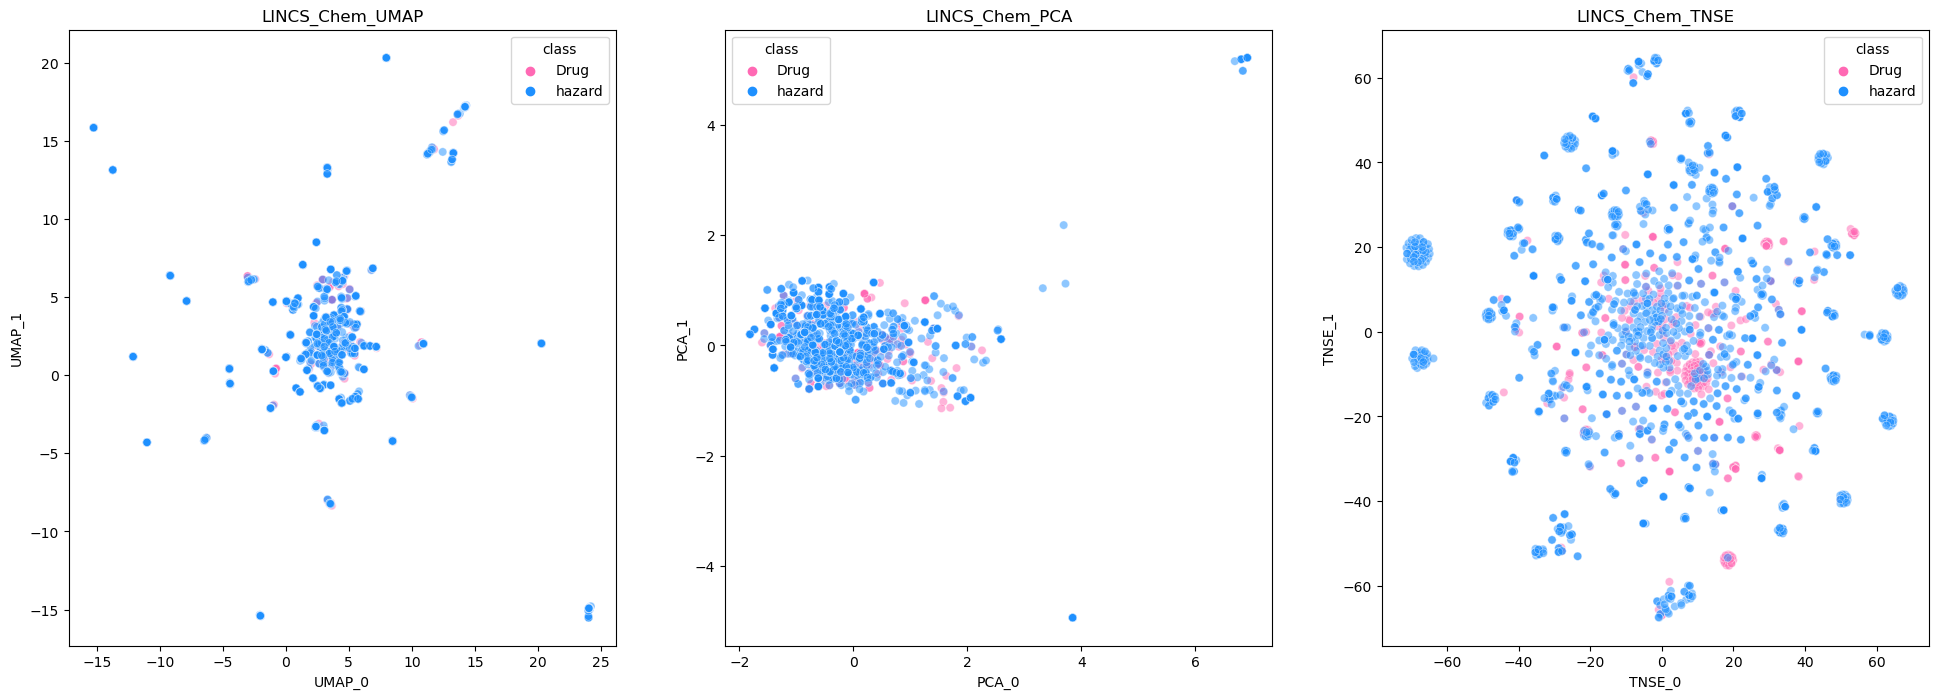

In [68]:
#df["mol"] = df["mol"].apply(get_largest_fragment_from_smiles).dropna()
data["mol"] = data["smiles"].apply(get_largest_fragment_from_smiles)
# Compute desrciptors and keep track of which failed to featurize
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(data["mol"])
# Only keep those that sucessfully featurized
data = data.iloc[keep_idx]

# umap
umap_model = umap.UMAP(metric = "jaccard", n_neighbors = 25, n_components = 2, low_memory = False, min_dist = 0.001)
X_umap = umap_model.fit_transform(ecfp_descriptors)
data["UMAP_0"], data["UMAP_1"] = X_umap[:,0], X_umap[:,1]
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(ecfp_descriptors)
data["PCA_0"], data["PCA_1"] = X_pca[:,0], X_pca[:,1]
# t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(ecfp_descriptors)
data["TNSE_0"], data["TNSE_1"] = X_tsne[:,0], X_tsne[:,1]

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
palette = sns.color_palette(["hotpink", "dodgerblue"])
sns.scatterplot(data=data,x=data["UMAP_0"], y=data["UMAP_1"],hue="class",alpha=0.5,palette=palette, ax=axes[0])
axes[0].set_title('LINCS_Chem_UMAP')
sns.scatterplot(data=data,x=data["PCA_0"], y=data["PCA_1"],hue="class",alpha=0.5,palette=palette, ax=axes[1])
axes[1].set_title('LINCS_Chem_PCA')
sns.scatterplot(data=data,x=data["TNSE_0"], y=data["TNSE_1"],hue="class",alpha=0.5,palette=palette, ax=axes[2])
axes[2].set_title('LINCS_Chem_TNSE')
plt.show()

In [69]:
from typing import List

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import hdbscan

# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [70]:
def plot_global_embeddings_with_clusters(df: pd.DataFrame,
                          x_col: str,
                          y_col: str,
                          cluster_col: str,
                          title: str = "",
                          x_lim = None,
                          y_lim = None):
    """ Plots data colored by soft HDBSCAN clusters
    
    If the cluster of a compund is not specified (cluster < 0), it will be
    plotted gray, otherwise it will be colored by the cluster value.
    """
    clustered = df[cluster_col].values >= 0
    
    plt.figure(figsize=(10,8))
    ax=sns.scatterplot(data=df.iloc[~clustered],
                    x=x_col,
                    y=y_col,
                    color=(0.5, 0.5, 0.5),
                    s=10,
                    alpha=0.1)
    sns.scatterplot(data=df.iloc[clustered],
                    x=x_col,
                    y=y_col,
                    hue=cluster_col,
                    alpha=0.5,
                    palette="nipy_spectral",
                    ax=ax)
    if x_lim:
      ax.set_xlim(x_lim)
    if y_lim:
      ax.set_ylim(y_lim)

    sm = plt.cm.ScalarMappable(cmap="nipy_spectral")
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm, label="Global Cluster")
  
    plt.title(title)
    plt.show()

/opt/anaconda3/envs/deepchem_py37/lib/python3.7/site-packages/umap/umap_.py:1804: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


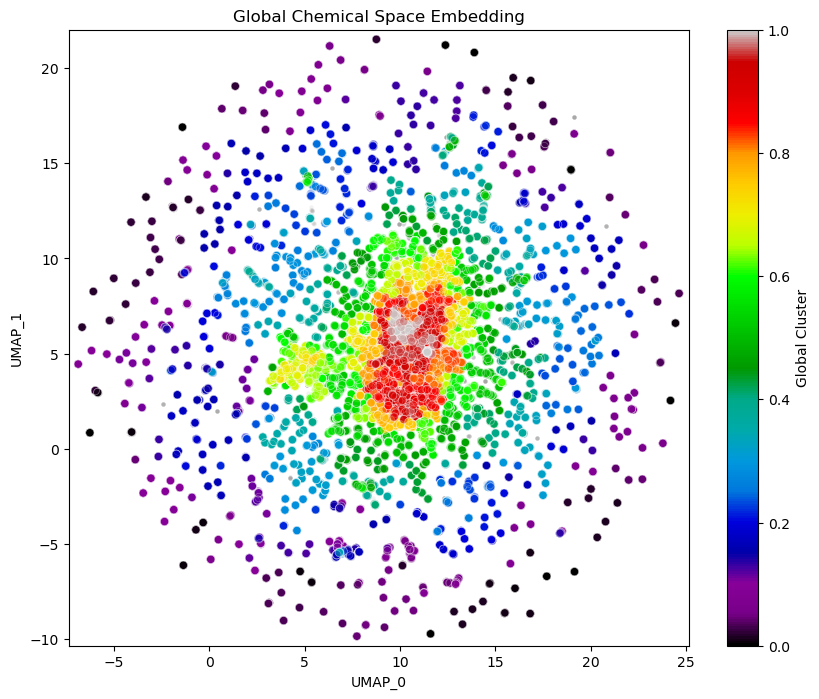

In [71]:
# Read in data from MoleculeNet
chembl = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/chembl_sparse.csv.gz", compression='gzip')
# Sample a random 10k
chembl_sample = chembl.sample(n=100000)
# Compute desrciptors and keep track of which failed to featurize
chembl_ecfp_descriptors, chembl_keep_idx = compute_ecfp_descriptors(chembl_sample["smiles"])
# Only keep those that sucessfully featurized
chembl_sample = chembl_sample.iloc[chembl_keep_idx]

umap_model_global = umap.UMAP(metric = "jaccard", n_neighbors = 25, n_components = 2, low_memory = False, min_dist = 0.001)
X_umap_global = umap_model_global.fit_transform(chembl_ecfp_descriptors)
chembl_sample["UMAP_0"], chembl_sample["UMAP_1"] = X_umap_global[:,0], X_umap_global[:,1]

# Define HDBSCAN model
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=10, prediction_data=True, cluster_selection_method="eom")
# Fit and predict on ChEMBL-sample
chembl_sample["global_cluster"] = hdbscan_model.fit_predict(X_umap_global)

buffer_space = 0.5 # Extra space around the edges
x_lim = chembl_sample["UMAP_0"].min()-buffer_space, chembl_sample["UMAP_0"].max()+buffer_space
y_lim = chembl_sample["UMAP_1"].min()-buffer_space, chembl_sample["UMAP_1"].max()+buffer_space
plot_global_embeddings_with_clusters(chembl_sample, x_col="UMAP_0", y_col="UMAP_1", x_lim=x_lim, y_lim=y_lim, cluster_col="global_cluster", title="Global Chemical Space Embedding")



In [ ]:
data_w_smiles["mol"] = data_w_smiles["smiles"].apply(get_largest_fragment_from_smiles)


ecfp_descriptors, keep_idx = compute_ecfp_descriptors(data_w_smiles["mol"])

X_umap = umap_model_global.transform(ecfp_descriptors)
data_w_smiles["UMAP_0 (global)"], data_w_smiles["UMAP_1 (global)"] = X_umap[:,0], X_umap[:,1]
data_w_smiles["global_cluster"], _ = hdbscan.approximate_predict(hdbscan_model, np.nan_to_num(X_umap, nan=0))
plot_global_embeddings_with_clusters(data_w_smiles, x_col="UMAP_0 (global)", y_col="UMAP_1 (global)", x_lim=x_lim, y_lim=y_lim, cluster_col="global_cluster", title="asdf")


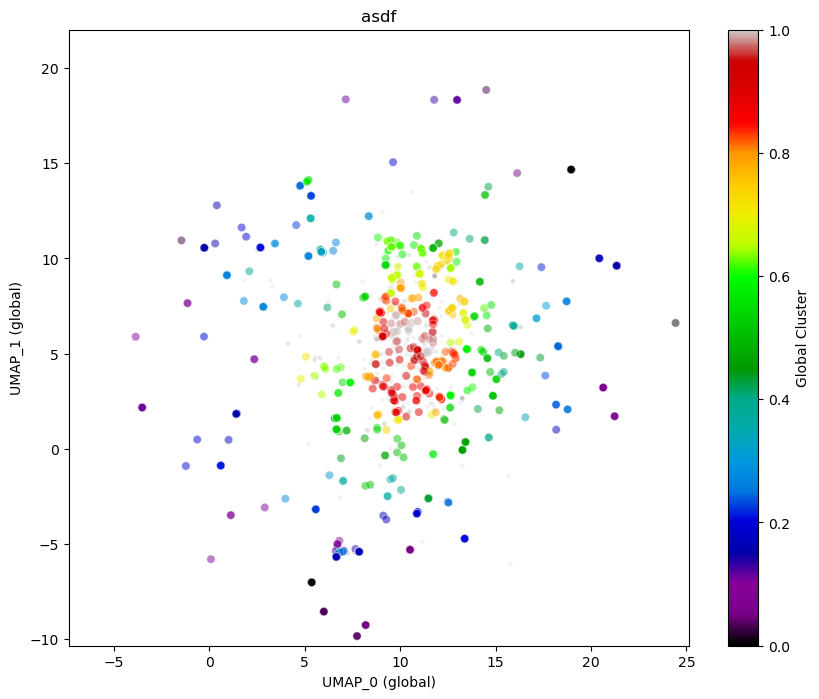

In [72]:
data["mol"] = data["smiles"].apply(get_largest_fragment_from_smiles)


ecfp_descriptors, keep_idx = compute_ecfp_descriptors(data["mol"])

X_umap = umap_model_global.transform(ecfp_descriptors)
data["UMAP_0 (global)"], data["UMAP_1 (global)"] = X_umap[:,0], X_umap[:,1]
data["global_cluster"], _ = hdbscan.approximate_predict(hdbscan_model, np.nan_to_num(X_umap, nan=0))
plot_global_embeddings_with_clusters(data, x_col="UMAP_0 (global)", y_col="UMAP_1 (global)", x_lim=x_lim, y_lim=y_lim, cluster_col="global_cluster", title="asdf")
